In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd
import random
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset
from typing import Any, Tuple
from PIL import Image
from torch import nn


class ImageNetDataset(Dataset):

    def __init__(self, root="ILSVRC2017_DET/ILSVRC/Data/DET/train/ILSVRC2014_train_000", multiplier=1, small_size=64, big_size=128):
        self.convert_tensor = transforms.ToTensor()
        self.root = root
        self.multiplier = multiplier
        self.small_transform = transforms.Compose([
            transforms.Resize((small_size, small_size))
        ])
        self.big_transform = transforms.Compose([
            transforms.Resize((big_size, big_size))
        ])
        return

    def __len__(self):
         return self.multiplier * 10000

    def __getitem__(self, idx)  -> Tuple[Any, Any]:
        in_folder_index = idx % 10000
        folder_index = int(idx / 10000)
        # image_path = self.root + str(folder_index) + "/ILSVRC2014_train_000" + str(folder_index) + "{:04d}".format(in_folder_index) + ".jpeg"
        image_path = self.root + str(folder_index) + "/ILSVRC2014_train_00000464" + ".jpeg"
        image = Image.open(image_path)
        # image = transforms.Grayscale(num_output_channels=3).forward(image)
        small_image = self.small_transform(image)
        big_image = self.big_transform(image)
        return self.convert_tensor(small_image), self.convert_tensor(big_image)
        # return small_image, big_image

batch_size = 100
train_dataset = ImageNetDataset()
to_img_transform = transforms.ToPILImage()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

3


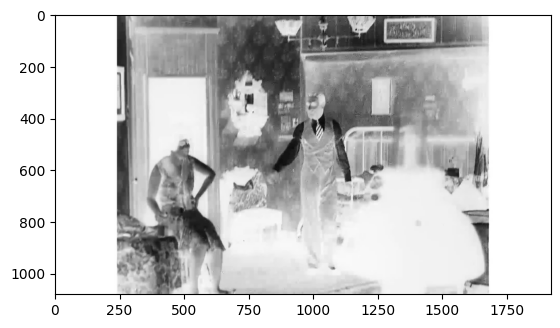

In [18]:
import matplotlib.pyplot as plt
image = Image.open("ILSVRC2017_DET/test_from_movie.jpg")
convert_tensor = transforms.ToTensor()
# image = transforms.Grayscale(num_output_channels=1).forward(image)
image = torchvision.transforms.functional.invert(image)
image.show()
plt.imshow(image)
print(len(convert_tensor(image)))
plt.show()x

In [2]:
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()

        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 9, 3, stride=2, padding=1),
            nn.BatchNorm2d(9),
            nn.ReLU(True),
            nn.Conv2d(9, 18, 3, stride=2, padding=1),
            nn.BatchNorm2d(18),
            nn.ReLU(True),
            nn.Conv2d(18, 24, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(24),
            nn.Conv2d(24, 36, 3, stride=2, padding=1),
            nn.ReLU(True)
        )

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(36 * 8 * 8, 8000),
            nn.ReLU(True),
            nn.Linear(8000, 4000),
            nn.ReLU(True),
            nn.Linear(4000, 2000)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class Decoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(2000, 4000),
            nn.ReLU(True),
            nn.Linear(4000, 8000),
            nn.ReLU(True),
            nn.Linear(8000, 36 * 8 * 8),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1,
                                      unflattened_size=(36, 8, 8))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(36, 24, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(True),
            nn.ConvTranspose2d(24, 18, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(18),
            nn.ReLU(True),
            nn.ConvTranspose2d(18, 9, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(9),
            nn.ReLU(True),
            nn.ConvTranspose2d(9, 3, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [3]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 32

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder()
decoder = Decoder()
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder = encoder.to(device)
decoder = decoder.to(device)

Selected device: cuda


In [4]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    i = 0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for small_image_batch, big_image_batch in dataloader:  # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        big_image_batch = big_image_batch.to(device)
        # Encode data
        encoded_data = encoder(big_image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, big_image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t %d partial train loss (single batch): %f' % (i, loss.data))
        i = i + 1
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)


In [5]:
diz_loss = {'train_loss':[],'val_loss':[]}

In [19]:
num_epochs = 2

for epoch in range(num_epochs):
    train_loss =train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
    # val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,0))
    diz_loss['train_loss'].append(train_loss)
    # diz_loss['val_loss'].append(val_loss)
    # plot_ae_outputs(encoder,decoder,n=10)

	 0 partial train loss (single batch): 0.001182
	 1 partial train loss (single batch): 0.001179
	 2 partial train loss (single batch): 0.001176
	 3 partial train loss (single batch): 0.001174
	 4 partial train loss (single batch): 0.001171
	 5 partial train loss (single batch): 0.001168
	 6 partial train loss (single batch): 0.001166
	 7 partial train loss (single batch): 0.001163
	 8 partial train loss (single batch): 0.001160
	 9 partial train loss (single batch): 0.001158
	 10 partial train loss (single batch): 0.001155
	 11 partial train loss (single batch): 0.001153
	 12 partial train loss (single batch): 0.001150
	 13 partial train loss (single batch): 0.001148
	 14 partial train loss (single batch): 0.001145
	 15 partial train loss (single batch): 0.001143
	 16 partial train loss (single batch): 0.001140
	 17 partial train loss (single batch): 0.001137
	 18 partial train loss (single batch): 0.001135
	 19 partial train loss (single batch): 0.001132
	 20 partial train loss (singl

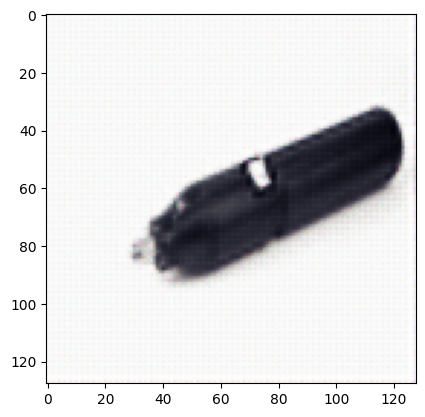

In [22]:
import matplotlib.pyplot as plt
transform_to_img = transforms.ToPILImage()
for small, big in train_loader:
    big_image_batch = big.to(device)
    # Encode data
    encoded_data = encoder(big_image_batch)
    # Decode data
    decoded_data = decoder(encoded_data)
    # plt.imshow(transform_to_img(big[22]))
    plt.imshow(transform_to_img(decoded_data[22]))
    plt.show()
    break